In [1]:
import os
import sys

from rdkit import Chem
from rdkit.Chem import AllChem

import numpy as np
import pandas as pd
import torch

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
BASE_DIR = ".."
MODEL_BASE_DIR = f"{BASE_DIR}/best_models"
DATA_DIR = f"{BASE_DIR}/nbdata"
os.makedirs(MODEL_BASE_DIR,exist_ok=True)
os.makedirs(DATA_DIR,exist_ok=True)
sys.path.append(BASE_DIR)

---

## Load DrugBank

In [4]:
def morgan_fingerprint(mol,radius=2,nbits=2048):
    return torch.from_numpy(np.array(AllChem.GetMorganFingerprintAsBitVect(mol,radius,nbits)))

In [5]:
molecules = Chem.SDMolSupplier('/afs/csail.mit.edu/u/s/samsl/Work/databases/DrugBank/all_structures.sdf')
moleculeDict = {m.GetProp('DRUGBANK_ID'): m for m in molecules if m is not None}

[14:03:47] Explicit valence for atom # 13 Cl, 5, is greater than permitted
[14:03:47] ERROR: Could not sanitize molecule ending on line 289199
[14:03:47] ERROR: Explicit valence for atom # 13 Cl, 5, is greater than permitted
[14:03:47] Explicit valence for atom # 19 O, 3, is greater than permitted
[14:03:47] ERROR: Could not sanitize molecule ending on line 399275
[14:03:47] ERROR: Explicit valence for atom # 19 O, 3, is greater than permitted
[14:03:47] Explicit valence for atom # 1 N, 4, is greater than permitted
[14:03:47] ERROR: Could not sanitize molecule ending on line 522730
[14:03:47] ERROR: Explicit valence for atom # 1 N, 4, is greater than permitted
[14:03:47] Explicit valence for atom # 1 N, 4, is greater than permitted
[14:03:47] ERROR: Could not sanitize molecule ending on line 578040
[14:03:47] ERROR: Explicit valence for atom # 1 N, 4, is greater than permitted
[14:03:47] Explicit valence for atom # 12 N, 4, is greater than permitted
[14:03:47] ERROR: Could not sanitize

In [7]:
import xml.etree.ElementTree as ET
full_drugbank = ET.parse('/afs/csail.mit.edu/u/s/samsl/Work/databases/DrugBank/full_database.xml')
drugbank_root = full_drugbank.getroot()
namespaces = {'drugbank': 'http://www.drugbank.ca'}

In [8]:
class ATC_Code:
    def __init__(self, xmlcode):
        self.code = c.attrib["code"]
        self.lvls = xmlcode.findall("drugbank:level",namespaces)
        self.lvl4 = (self.lvls[0].attrib["code"], self.lvls[0].text)
        self.lvl3 = (self.lvls[1].attrib["code"], self.lvls[1].text)
        self.lvl2 = (self.lvls[2].attrib["code"], self.lvls[2].text)
        self.lvl1 = (self.lvls[3].attrib["code"], self.lvls[3].text)
        
    def __repr__(self):
        return f"{self.code} ({self.lvl1[1]}, {self.lvl2[1]}, {self.lvl3[1]}, {self.lvl4[1]})"
    
    def __eq__(self, other):
        return self.code == other.code
    
class Drug:
    def __init__(self, dbid, smiles, codes):
        self.name = dbid
        self.smiles = smiles
        self.codes = codes
        
        self.embeddings = {}

    def __repr__(self):
        return f"{self.name}: {[i for i in self.codes]}"
        
    def __eq__(self, other):
        return self.name == other.name

    def setRDKitMol(self,m):
        self.rdkitmol = m
        
    def getRDKitMol(self):
        return self.rdkitmol
        
    def setEmbedding(self,embName,embedding):
        self.embeddings[embName] = embedding
        
    def getEmbedding(self,embName):
        return self.embeddings[embName]

In [10]:
drugDict = {}

for drxml in tqdm(drugbank_root, total=len(drugbank_root)):
    dbid = drxml.find('drugbank:drugbank-id[@primary="true"]',namespaces).text
    if dbid in moleculeDict.keys():
        codesxml = drxml.findall('drugbank:atc-codes/drugbank:atc-code', namespaces)
        codesclass = []
        for c in codesxml:
            codesclass.append(ATC_Code(c))
        drclass = Drug(dbid, moleculeDict[dbid].GetProp('SMILES'), codesclass)
        drugDict[dbid] = drclass
    else:
        continue

  0%|          | 0/14594 [00:00<?, ?it/s]

In [11]:
print(len(drugDict),'drugs from DrugBank')

11290 drugs from DrugBank


In [12]:
drugDict['DB00006']

DB00006: [B01AE06 (BLOOD AND BLOOD FORMING ORGANS, ANTITHROMBOTIC AGENTS, ANTITHROMBOTIC AGENTS, Direct thrombin inhibitors)]

In [17]:
topLvlClasses = {}

for k,v in drugDict.items():
    if len(v.codes):
        topLvlClasses[k] = v.codes[0].lvl1[0]
    else:
        topLvlClasses[k] = '-'

In [18]:
from collections import Counter
cntr = Counter(topLvlClasses.values())
cntr

Counter({'B': 94,
         'L': 231,
         'R': 201,
         'H': 42,
         '-': 8447,
         'J': 305,
         'A': 329,
         'V': 152,
         'G': 163,
         'D': 174,
         'N': 478,
         'S': 98,
         'M': 138,
         'C': 345,
         'P': 93})

---

## Load Surfaceome

In [19]:
tdb = pd.read_excel('/afs/csail.mit.edu/u/s/samsl/Work/databases/surfaceome/table_S3_surfaceome.xlsx')
tdb.columns = tdb.iloc[0]

/afs/csail.mit.edu/u/s/samsl/Work/anaconda3/envs/dsplat/lib/python3.7/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [20]:
surface_db = tdb[tdb['Surfaceome Label'] == 'surface']

In [21]:
surface_db.columns

Index(['UniProt name', 'UniProt accession', 'UniProt description',
       'UniProt gene', 'Surfaceome Label', 'Surfaceome Label Source',
       'Comment', 'length', 'TM domains', 'signalpeptide', 'topology',
       'topology source', 'MachineLearning trainingset',
       'MachineLearning score',
       'MachineLearning FPR class (1=1%, 2=5%, 3=15%)', 'Ensembl gene',
       'Ensembl protein', 'CD number', 'Membranome Almen main-class',
       'Membranome Almen sub-class', 'nxst motifs', 'noncyt. nxst count',
       'peps with accessible noncyt. nxst', 'noncyt. Trp count',
       'peps with accessible noncyt. Trp', 'noncyt. Tyr count',
       'peps with accessible noncyt. Tyr', 'glycomineN sites',
       'glycomineO sites', 'glycomineC sites', 'CSPA category',
       'CSPA peptide count', 'CSPA peptides', 'CSPA N115 sites', 'CSPA id',
       'UniProt subcellular', 'UniProt keywords', 'UniProt uniref',
       'COMPARTMENTS link', 'COMPARTMENTS benchmark pos',
       'COMPARTMENTS benchmar

In [22]:
surface_db[['UniProt accession', 'Ensembl gene','length','TM domains','Membranome Almen main-class','UniProt subcellular']]

,UniProt accession,Ensembl gene,length,TM domains,Membranome Almen main-class,UniProt subcellular
2217,A0AV02,ENSG00000221955,714,13,Transporters,Membrane (Multi-pass membrane protein)
2218,A0FGR9,ENSG00000158220,886,2,Unclassified,Cell membrane (Peripheral membrane protein);En...
2219,A0PJK1,ENSG00000154025,596,14,Transporters,Cell membrane (Multi-pass membrane protein)
2220,A0PK11,ENSG00000249581,232,4,Unclassified,Membrane (Multi-pass membrane protein)
2221,A0ZSE6,ENSG00000235156,113,1,Miscellaneous,Membrane (Single-pass membrane protein)
...,...,...,...,...,...,...
5098,Q9Y6N8,ENSG00000040731,788,1,Miscellaneous,Cell membrane (Single-pass type I membrane pro...
5099,Q9Y6Q6,ENSG00000141655,616,1,Receptors,Cell membrane (Single-pass type I membrane pro...
5100,Q9Y6R1,ENSG00000080493,1079,10,Transporters,Basolateral cell membrane (Multi- pass membran...
5101,Q9Y6W8,ENSG00000163600,199,1,Unclassified,Cell membrane (Single-pass type I membrane pro...


In [632]:
### Write list of sequences

with open('/afs/csail.mit.edu/u/s/samsl/Work/databases/surfaceome/surface_uniprot_list.txt','w+') as f:
    for p in surface_db['UniProt accession'].to_list():
        f.write(f"{p}\n")
        
### Download these sequences from UniProt

In [23]:
updb = pd.read_csv('/afs/csail.mit.edu/u/s/samsl/Work/databases/surfaceome/surfaceome_uniprot_download.tsv',sep='\t')
updb = updb[~updb['Sequence'].isna()]

In [24]:
updb.head()

,Entry,Protein names,Gene names,Organism,Length,Sequence,EC number,Cross-reference (Pfam),Cross-reference (BindingDB),Cross-reference (DrugBank)
0,A0AV02,Solute carrier family 12 member 8 (Cation-chlo...,SLC12A8 CCC9,Homo sapiens (Human),714.0,MTQMSQVQELFHEAAQQDALAQPQPWWKTQLFMWEPVLFGTWDGVF...,NaN,PF00324;,NaN,NaN
1,A0FGR9,Extended synaptotagmin-3 (E-Syt3) (Chr3Syt),ESYT3 FAM62C,Homo sapiens (Human),886.0,MRAEEPCAPGAPSALGAQRTPGPELRLSSQLLPELCTFVVRVLFYL...,NaN,PF00168;PF17047;,NaN,NaN
2,A0PJK1,Sodium/glucose cotransporter 5 (Na(+)/glucose ...,SLC5A10 SGLT5,Homo sapiens (Human),596.0,MAANSTSDLHTPGTQLSVADIIVITVYFALNVAVGIWSSCRASRNT...,NaN,PF00474;,NaN,NaN
3,A0PK11,Clarin-2,CLRN2,Homo sapiens (Human),232.0,MPGWFKKAWYGLASLLSFSSFILIIVALVVPHWLSGKILCQTGVDL...,NaN,NaN,NaN,NaN
4,A0ZSE6,Cell cycle control protein 50C (Transmembrane ...,TMEM30CP CDC50C TMEM30C,Homo sapiens (Human),113.0,MEERAQHCLSRLLDNSALKQQELPIHRLYFTARRVLFVFFATGIFC...,NaN,NaN,NaN,NaN


In [25]:
mrgdb = pd.merge(surface_db, updb, left_on='UniProt accession', right_on='Entry',how='inner')

In [172]:
with open('/afs/csail.mit.edu/u/s/samsl/Work/databases/surfaceome/surfaceome_uniprot_seqs.fasta','w+') as f:
    for i,r in mrgdb.iterrows():
        f.write(f">{r.Entry}\n{r.Sequence}\n")

### Domain Annotation

In [635]:
#!/scratch1/rsingh/tools/bin/hmmscan -o /afs/csail.mit.edu/u/s/samsl/Work/databases/surfaceome/surfaceome_pfam_scan.out --tblout /afs/csail.mit.edu/u/s/samsl/Work/databases/surfaceome/surfaceome_pfam_scan.tblout --domtblout /afs/csail.mit.edu/u/s/samsl/Work/databases/surfaceome/surfaceome_pfam_scan.domtblout --acc --noali --notextw --cut_ga /afs/csail.mit.edu/u/r/rsingh/work/corals/data/raw/pfam/Pfam-A.hmm /afs/csail.mit.edu/u/s/samsl/Work/databases/surfaceome/surfaceome_uniprot_seqs.fasta 

In [26]:
from Bio.SearchIO.HmmerIO.hmmer3_tab import Hmmer3TabParser

In [27]:
with open('/afs/csail.mit.edu/u/s/samsl/Work/databases/surfaceome/surfaceome_pfam_scan.tblout','r') as f:
    hmmerhits = list(Hmmer3TabParser(f))

In [28]:
domtbl = []

for rec in hmmerhits:
    for hit in rec.hits:
        domtbl.append((rec.id, hit.id, hit.accession, hit.evalue, hit.bitscore))
        
domtbl = pd.DataFrame(domtbl,columns=['Query','DomName','DomAccession','eval','bitscore'])

In [29]:
grpdomtbl = domtbl.groupby('Query')['DomName','DomAccession'].transform(lambda x: ','.join(x))
grpdomtbl.index = domtbl.Query
grpdomtbl = grpdomtbl.reset_index().drop_duplicates()

/afs/csail.mit.edu/u/s/samsl/Work/anaconda3/envs/dsplat/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


In [30]:
full_dom_db = pd.merge(mrgdb,grpdomtbl,left_on='Entry', right_on='Query', how='inner')
full_dom_db = full_dom_db.set_index('UniProt accession')
full_dom_db.head()

,UniProt name,UniProt description,UniProt gene,Surfaceome Label,Surfaceome Label Source,Comment,length,TM domains,signalpeptide,topology,...,Organism,Length,Sequence,EC number,Cross-reference (Pfam),Cross-reference (BindingDB),Cross-reference (DrugBank),Query,DomName,DomAccession
UniProt accession,,,,,,,,,,,,,,,,,,,,,
A0AV02,S12A8_HUMAN,Solute carrier family 12 member 8,SLC12A8,surface,machine learning,NaN,714,13,0,NC:1-37;TM:38-60;CY:61-71;TM:72-93;NC:94-98;TM...,...,Homo sapiens (Human),714.0,MTQMSQVQELFHEAAQQDALAQPQPWWKTQLFMWEPVLFGTWDGVF...,NaN,PF00324;,NaN,NaN,A0AV02,AA_permease,PF00324.22
A0FGR9,ESYT3_HUMAN,Extended synaptotagmin-3,ESYT3,surface,pos. trainingset,NaN,886,2,0,CY:1-27;TM:28-46;NC:47-51;TM:52-72;CY:73-886,...,Homo sapiens (Human),886.0,MRAEEPCAPGAPSALGAQRTPGPELRLSSQLLPELCTFVVRVLFYL...,NaN,PF00168;PF17047;,NaN,NaN,A0FGR9,"SMP_LBD,C2","PF17047.6,PF00168.31"
A0PJK1,SC5AA_HUMAN,Sodium/glucose cotransporter 5,SLC5A10,surface,machine learning,NaN,596,14,0,NC:1-15;TM:16-37;CY:38-73;TM:74-93;NC:94-98;TM...,...,Homo sapiens (Human),596.0,MAANSTSDLHTPGTQLSVADIIVITVYFALNVAVGIWSSCRASRNT...,NaN,PF00474;,NaN,NaN,A0PJK1,SSF,PF00474.18
A1A5B4,ANO9_HUMAN,Anoctamin-9,ANO9,surface,pos. trainingset,NaN,782,8,0,CY:1-195;TM:196-217;NC:218-266;TM:267-285;CY:2...,...,Homo sapiens (Human),782.0,MQGEESLRILVEPEGDSFPLMEISTCETEASEQWDYVLVAQRHTQR...,NaN,PF04547;,NaN,NaN,A1A5B4,"Anoctamin,Anoct_dimer","PF04547.13,PF16178.6"
A1A5C7,S22AN_HUMAN,Solute carrier family 22 member 23,SLC22A23,surface,machine learning,NaN,686,10,0,NC:1-230;TM:231-253;CY:254-258;TM:259-280;NC:2...,...,Homo sapiens (Human),686.0,MAIDRRREAAGGGPGRQPAPAEENGSLPPGDAAASAPLGGRAGPGG...,NaN,PF00083;,NaN,NaN,A1A5C7,"Sugar_tr,MFS_1","PF00083.25,PF07690.17"


---

# Project into common space

In [35]:
from architectures import SimplePLMModel, SimpleCosine

In [36]:
# Load model
from mol_feats import Morgan_f
from prot_feats import ProtBert_f
mol_f = Morgan_f()
prot_f = ProtBert_f()
# model = torch.load("../best_models/dti_dg_morganM_protbertP_bm_best_model.sav").cuda()
model = torch.load("../best_models/bindingdb_morgan_protbert_best_model.sav").cuda()

/afs/csail.mit.edu/u/s/samsl/.local/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
/afs/csail.mit.edu/u/s/samsl/.local/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:167: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html

In [37]:
model

SimpleCosine(
  (mol_projector): Sequential(
    (0): Linear(in_features=2048, out_features=1024, bias=True)
    (1): ReLU()
  )
  (prot_projector): Sequential(
    (0): Linear(in_features=1024, out_features=1024, bias=True)
    (1): ReLU()
  )
  (activator): Cosine()
)

In [38]:
prot_names = []
prot_domains = []
prot_projections = []
mol_names = []
mol_projections = []

with torch.set_grad_enabled(False):
    for _, r in tqdm(full_dom_db.iterrows(),total=len(full_dom_db)):
        seq = r.Sequence
        seqName = r.Query
        prot_emb = prot_f(seq).unsqueeze(0).cuda()
        prot_proj = model.prot_projector(prot_emb).detach().cpu().numpy()
        prot_names.append(seqName)
        prot_domains.append(r.DomAccession)
        prot_projections.append(prot_proj)

    for molName, mol in tqdm(moleculeDict.items(),total=len(moleculeDict)):
        mol_emb = mol_f(Chem.MolToSmiles(mol)).unsqueeze(0).cuda()
        mol_proj = model.mol_projector(mol_emb).detach().cpu().numpy()
        mol_names.append(molName)
        mol_projections.append(mol_proj)

  0%|          | 0/2716 [00:00<?, ?it/s]

  0%|          | 0/11290 [00:00<?, ?it/s]

[14:46:59] WARNING: not removing hydrogen atom without neighbors
[14:46:59] WARNING: not removing hydrogen atom without neighbors
[14:46:59] WARNING: not removing hydrogen atom without neighbors
[14:46:59] WARNING: not removing hydrogen atom without neighbors


In [39]:
mol_projections = np.stack(mol_projections).squeeze()
prot_projections = np.stack(prot_projections).squeeze()

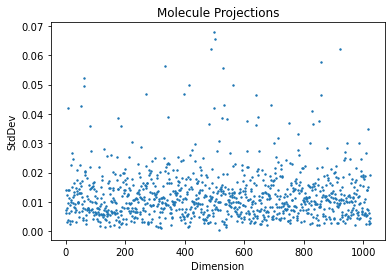

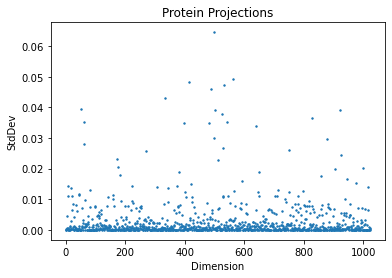

In [40]:
plt.scatter(np.arange(1024), mol_projections.squeeze().std(axis=0),s=2)
plt.title('Molecule Projections')
plt.xlabel('Dimension')
plt.ylabel('StdDev')
plt.show()

plt.scatter(np.arange(1024), prot_projections.squeeze().std(axis=0),s=2)
plt.title('Protein Projections')
plt.xlabel('Dimension')
plt.ylabel('StdDev')
plt.show()

In [41]:
from sklearn.manifold import TSNE

/afs/csail.mit.edu/u/s/samsl/.local/lib/python3.7/site-packages/sklearn/decomposition/online_lda.py:29: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  EPS = np.finfo(np.float).eps


In [42]:
all_embeddings = np.concatenate([prot_projections,mol_projections],axis=0)

In [43]:
embed_tsne = TSNE(metric="cosine").fit_transform(all_embeddings)

/afs/csail.mit.edu/u/s/samsl/.local/lib/python3.7/site-packages/sklearn/manifold/t_sne.py:344: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  error = np.finfo(np.float).max
/afs/csail.mit.edu/u/s/samsl/.local/lib/python3.7/site-packages/sklearn/manifold/t_sne.py:345: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  best_error = np.finfo(np.fl

---

# Visualize space by categories

In [72]:
domtbl.groupby('DomAccession').Query.count().sort_values(ascending=False).head(20)

DomAccession
PF00001.22    699
PF13853.7     445
PF00047.26    265
PF13927.7     247
PF10320.10    239
PF07686.18    230
PF07679.17    218
PF13895.7     217
PF00028.18    114
PF00041.22    103
PF08205.13     99
PF07690.17     94
PF13855.7      90
PF08266.13     89
PF10328.10     84
PF12799.8      82
PF07714.18     68
PF00069.26     68
PF16184.6      67
PF07654.16     61
Name: Query, dtype: int64

In [45]:
def get_pfd_code(code):
    is_pfd = ['yes' if code in full_dom_db.loc[i,'DomAccession'] else 'no' for i in prot_names]
    # is_pfd = is_pfd + ['mol']*mol_projections.shape[0]
    print(sum([1 if i=='yes' else 0 for i in is_pfd]))
    return is_pfd

In [46]:
almen_class = [mrgdb.set_index('UniProt accession').loc[i, 'Membranome Almen main-class'] for i in prot_names]

61


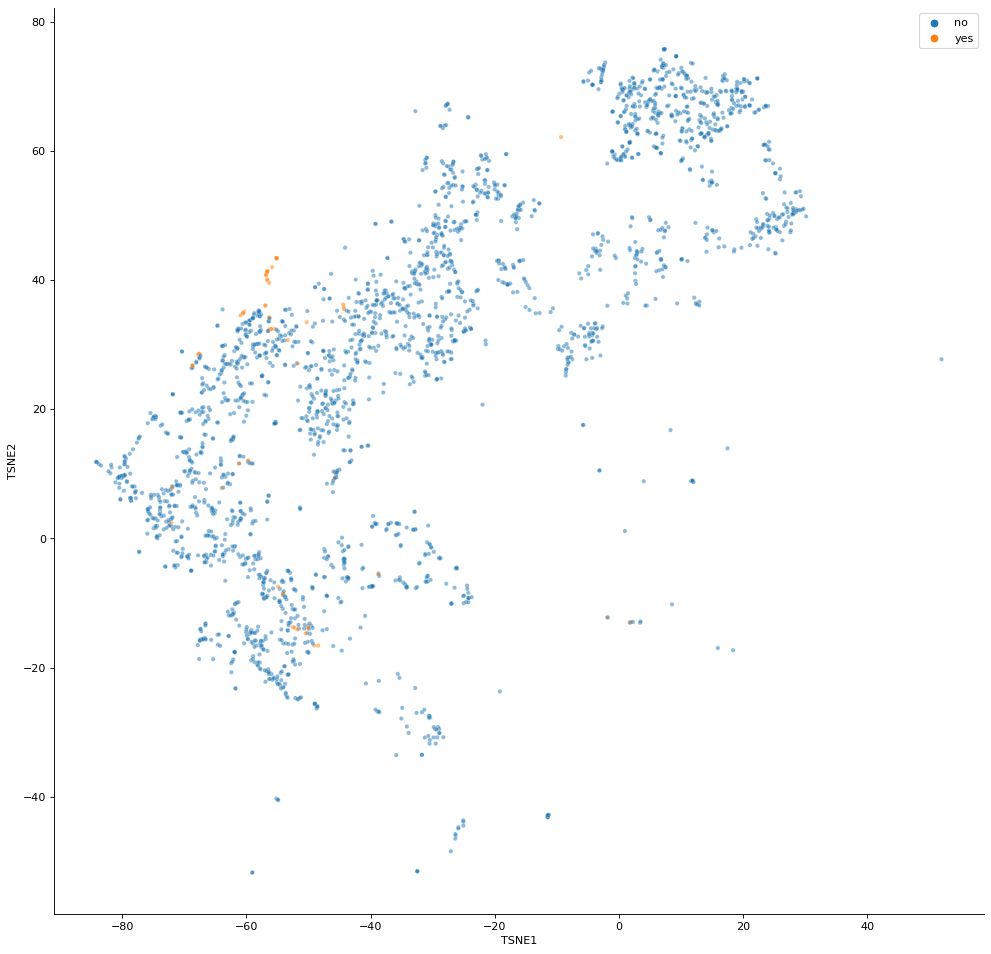

In [74]:
style = ['Protein'] * prot_projections.shape[0]# + ['Molecule'] * mol_projections.shape[0]
plt.figure(figsize=(15, 15), dpi=80)
sns.scatterplot(x=embed_tsne[:prot_projections.shape[0],0],
                y=embed_tsne[:prot_projections.shape[0],1],
                hue=get_pfd_code('PF07654.16'),
                # hue=get_pfd_code('PF07686.18'),
                # hue=almen_class,
                # hue = style,
                s=15,alpha=0.5
               )
plt.xlabel('TSNE1')
plt.ylabel('TSNE2')
sns.despine()
plt.show()

---
# Pairwise scores# predictions = []

In [659]:
from torch.nn import CosineSimilarity
from scipy.spatial.distance import cosine
cosine_sim = CosineSimilarity(dim=0)

predictions = []
for pName, pProj in tqdm(zip(prot_names,prot_projections),total=len(prot_names)):
        for mName, mProj in zip(mol_names,mol_projections):
            with torch.set_grad_enabled(False):
                affin = cosine_sim(torch.from_numpy(pProj),torch.from_numpy(mProj)).numpy()
                predictions.append((seqName, molName, affin))

  0%|          | 0/2716 [00:00<?, ?it/s]

In [ ]:
pred_df = pd.DataFrame(predictions,columns=['Target','Molecule','CosineSim'])
pred_df.head()

In [ ]:
pred_df.CosineSim.describe()

In [ ]:
pred_df.head()

In [ ]:
pred_df.to_csv('../nbdata/drugbank_x_surfaceome_classification_2022-06-06.csv',sep=',',header=True,index=False)